In [16]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/silica_opt_insilico/')
from silica_opt_insilico import experiment, execute, data_processing, post_process, contour_animated, bayesian_optimization, init_sampling
from saxs_data_processing import target_comparison
    
import numpy as np
import matplotlib.pyplot as plt

import pickle
import matplotlib.animation as animation
from IPython.display import HTML

import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## In silico optimization simulation

- objective functions work on volume fractions
- BO works on bounds/0-1


Ground truth:

- Diameter 80nm at [0.007, 0.018, 0.04]
- PDI min at [0.007, 0.025, 0.03]

## Parameters 

### SAXS Data processing parameters

### Experiment 'execution' parameters

In [2]:
# physical experiment bounds

teos_min_vf = 0.005
ammonia_min_vf = 0.005
water_min_vf = 0.005

teos_max_vf = 0.1
ammonia_max_vf = 0.1
water_max_vf = 0.15

noise_frac = 0.5 # what fraction of experimental noise to use

target_r_nm = 40 # particle size target

budget = 100

In [31]:
true_min = [6.936e-03, 2.021e-02, 4.000e-02]

### Campaign structure 

### 2. Calculate scattering

In [3]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1001 # number of grid points to interpolate q on.

In [4]:

target_r_angs = target_r_nm*10
target_pdi = 0.1
sld_silica = 8.575
sld_etoh = 9.611

In [5]:
q_grid = np.linspace(np.log10(q_min_spl), np.log10(q_max_spl), n_interpolate_gridpts)

q_grid_nonlog = 10**q_grid
target_I = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, target_pdi, sld_silica, sld_etoh)
target_I = np.log10(target_I)

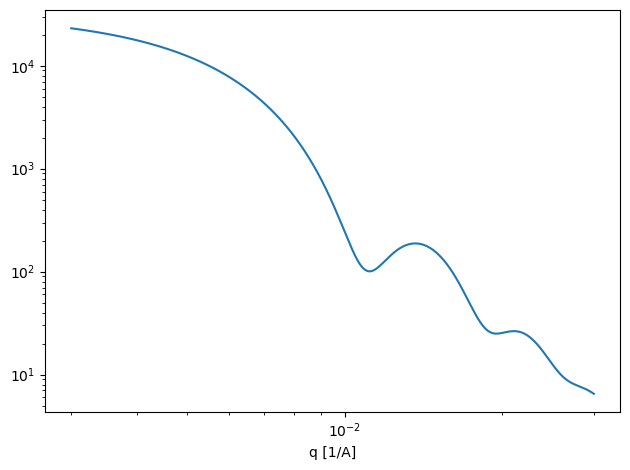

In [6]:
fig, ax = plt.subplots()
ax.loglog(10**q_grid, 10**target_I)
ax.set_xlabel('q [1/A]')

plt.tight_layout()


In [7]:
trials = {'baseline':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.05,
        'characterization':'SAXS',
        'distance':'apdist'
        },
     'noise_1':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':1,
        'characterization':'SAXS',
        'distance':'apdist'
        },
     'as_run_now':{
        'batch_size':10,
        'amplitude_weight':0.5,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':1,
        'characterization':'SAXS',
        'distance':'apdist'
        },
     'DLS':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.05,
        'characterization':'DLS',
        'pdi_weight':0.5,
        'distance':'apdist'
        },
     'rmse':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.05,
        'characterization':'SAXS',
        'distance':'rmse'
        },
     'batch_size_10':{
        'batch_size':10,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.05,
        'characterization':'SAXS',
        'distance':'apdist'
        },
     'restricted_bounds':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.06, 0.08, 0.08], 
        'noise_level':0.05,
        'characterization':'SAXS',
        'distance':'apdist'
        },
    'SobolBaseline':{
        'batch_size':5,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.05,
        'characterization':'SAXS',
        'distance':'apdist'
        },
    }

In [11]:
trials_3 = {'BO_GPR_baseline':{
        'batch_size':1,
        'amplitude_weight':0.1,
        'm_samples':5,
        'lower_bounds':[0.005, 0.005, 0.005], 
        'upper_bounds':[0.1, 0.1, 0.15], 
        'noise_level':0.05,
        'characterization':'SAXS',
        'distance':'apdist'
        },
}


In [63]:
noise_level

0.05

In [65]:
var_test_points = [[0.007, 0.02, 0.04], [0.09, 0.006, 0.14], [0.08, 0.099, 0.08]]

In [70]:
def estimate_variance(var_test_points, target_I, q_grid, amplitude_weight, noise_level, characterization, distance_metric, pdi_weight, target_d, target_pdi, n_rep = 10):
    variances = []
    for point in var_test_points:
        uuid_val = 'null'
        sample = {'teos_vol_frac':point[0], 'ammonia_vol_frac':point[1], 'water_vol_frac':point[2]}

        samples_list = []
        distances = []
        for i in range(n_rep):
            _, samp = execute.process_sample(uuid_val, sample, target_I, q_grid, amplitude_weight, noise_level, characterization =  characterization, distance_metric = distance_metric, pdi_weight = pdi_weight, target_d = target_d, target_pdi = target_pdi)
            samples_list.append(samp)
            distances.append(samp['distance'])

        var = np.var(distances)
        variances.append(var)

    return np.mean(variances)
            
        

In [71]:
budget = 10
n_replicates = 1
sobol_seed = 42
NUM_RESTARTS = 50
RAW_SAMPLES = 512
nu = 5/2
ard_num_dims = 3



for trial_name, params in trials_3.items():
    batch_size = params['batch_size']
    amplitude_weight = params['amplitude_weight']
    m_samples = params['m_samples']
    lower_bounds = params['lower_bounds']
    upper_bounds = params['upper_bounds']
    noise_level = params['noise_level']
    characterization = params['characterization']
    distance_metric = params.get('distance', None)
    pdi_weight = params.get('pdi_weight', None)


    y_var = estimate_variance(var_test_points, target_I, q_grid, amplitude_weight, noise_level, characterization, distance_metric, pdi_weight, target_d, target_pdi, n_rep = 10)
    print('Estimated y variance: ', y_var)
    target_d = target_r_nm*2

    if trial_name in ['baseline', 'noise_1', 'as_run_now', 'DLS']:
        continue

    print(distance)

    if batch_size == 0:
        n_batches = 0
    else:
        n_batches = int(np.ceil(budget/batch_size))
    
    bounds_torch_norm = torch.tensor([(lower_bounds[0], upper_bounds[0]), (lower_bounds[1], upper_bounds[1]), (lower_bounds[2], upper_bounds[2])]).transpose(-1, -2)
    bounds_torch_opt = torch.tensor([[0, 0, 0], [1.0, 1.0, 1.0]], dtype = torch.float32)

    print(f'Running optimization for trial {trial_name}')
    for rep_num in range(n_replicates):
        print(f'### Replicate {rep_num} ###')

        print('starting initial samples')
        initial_samples = init_sampling.sobol_sample(m_samples, sobol_seed, lower_bounds, upper_bounds)
        
        # 2. 'measure' sobol samples
        
        execute.batch_experiment(initial_samples, target_I, q_grid, amplitude_weight, noise_level, characterization, pdi_weight, distance_metric, target_d, target_pdi)
        
        # 3. start experiment loop:
        data = initial_samples
        models = []
        acqfs = []
        train_x_list = []
        train_y_list = []
        candidates_list = []
        for i in range(n_batches):
            print(f'starting batch {i+1}')
            # 3a. Prepare and run BO
            x_train, y_train = bayesian_optimization.bo_preprocess(data, bounds_torch_norm)
            candidates, model, train_x, train_y, acqf = bayesian_optimization.bayesian_optimize(x_train, y_train, batch_size, NUM_RESTARTS, RAW_SAMPLES, nu, ard_num_dims, bounds_torch_opt, bounds_torch_norm, return_model = True, y_var_scale = y_var)
            candidates_raw = candidates
            candidates = bayesian_optimization.bo_postprocess(candidates)
            models.append(model)
            acqfs.append(acqf)
            train_x_list.append(train_x)
            train_y_list.append(train_y)
            candidates_list.append(candidates_raw)
        
            # run experiment
            execute.batch_experiment(candidates, target_I, q_grid, amplitude_weight, noise_level, characterization, pdi_weight, distance_metric, target_d, target_pdi)
        
            # update running data tally
            for uuid_val, sample in candidates.items():
                data[uuid_val] = sample

        
        with open(f'{trial_name}_replicate_{rep_num}.pkl', 'wb') as f:
            pickle.dump(data, f)

Estimated y variance:  0.0001446084855551512
apdist
Running optimization for trial BO_GPR_baseline
### Replicate 0 ###
starting initial samples
batch distance metric:  apdist
starting batch 1
Optimized acqf in 1.667323112487793 s
batch distance metric:  apdist
starting batch 2
Optimized acqf in 1.109050989151001 s
batch distance metric:  apdist
starting batch 3
Optimized acqf in 2.8007290363311768 s
batch distance metric:  apdist
starting batch 4
Optimized acqf in 4.603156805038452 s
batch distance metric:  apdist
starting batch 5
Optimized acqf in 4.655975341796875 s
batch distance metric:  apdist
starting batch 6
Optimized acqf in 1.9430770874023438 s
batch distance metric:  apdist
starting batch 7
Optimized acqf in 4.245087146759033 s
batch distance metric:  apdist
starting batch 8
Optimized acqf in 0.0678408145904541 s
batch distance metric:  apdist
starting batch 9
Optimized acqf in 11.84651231765747 s
batch distance metric:  apdist
starting batch 10
Optimized acqf in 11.732127189

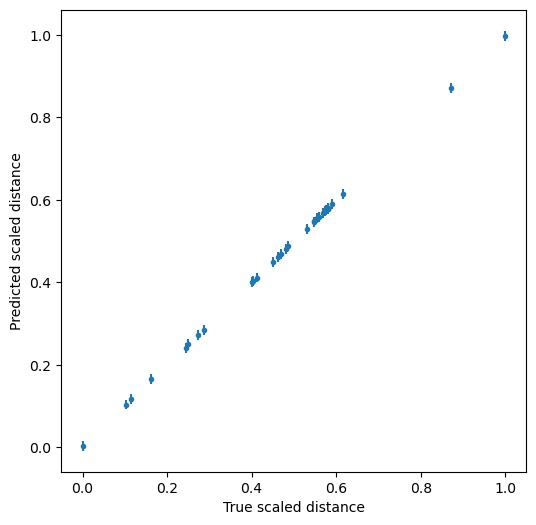

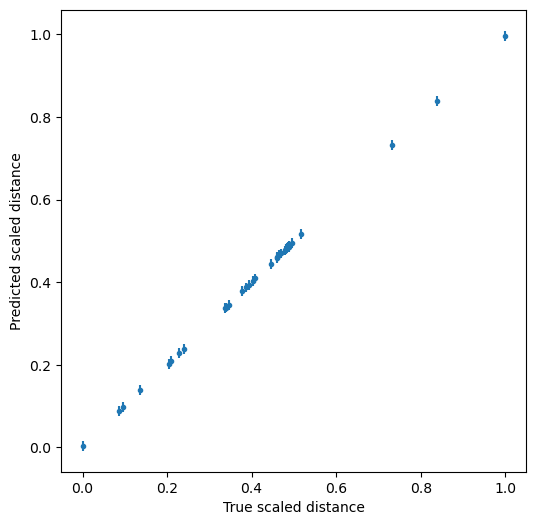

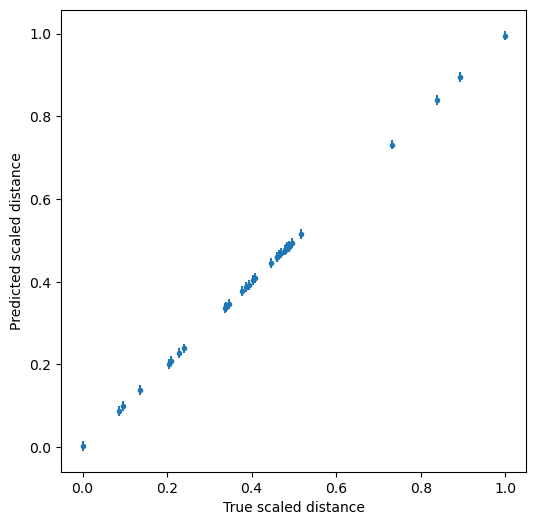

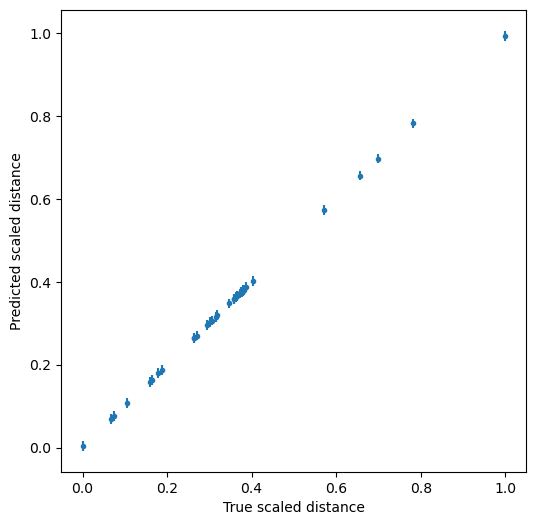

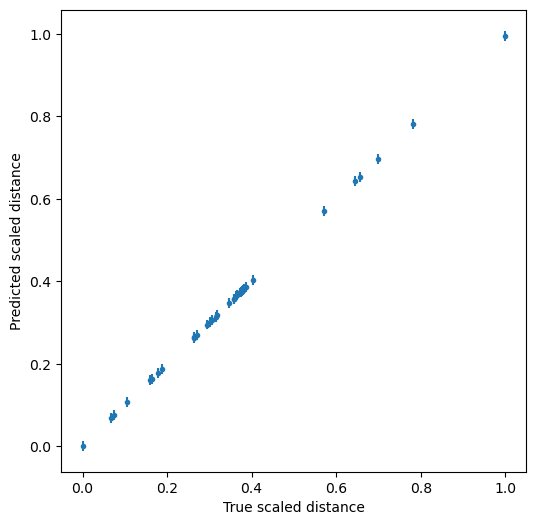

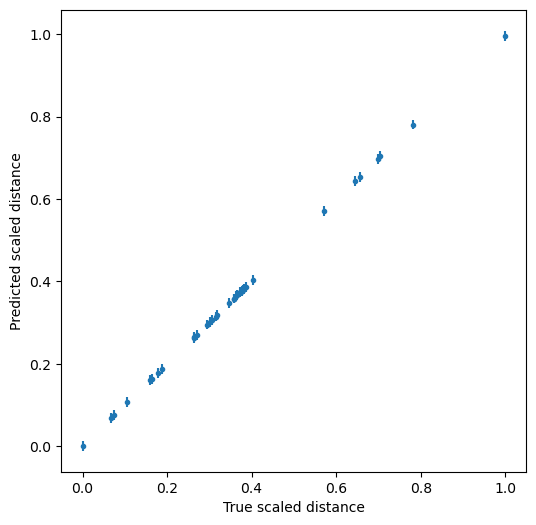

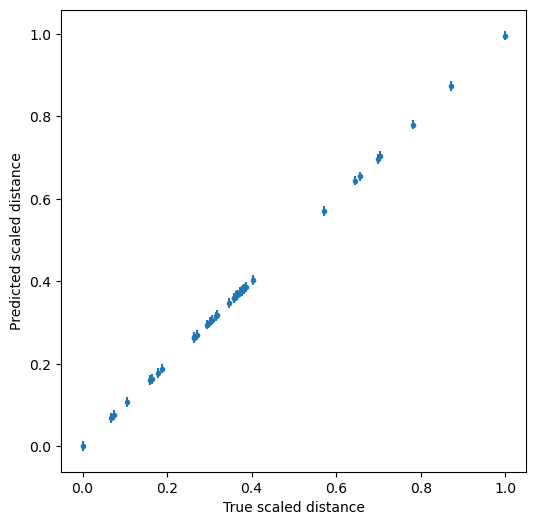

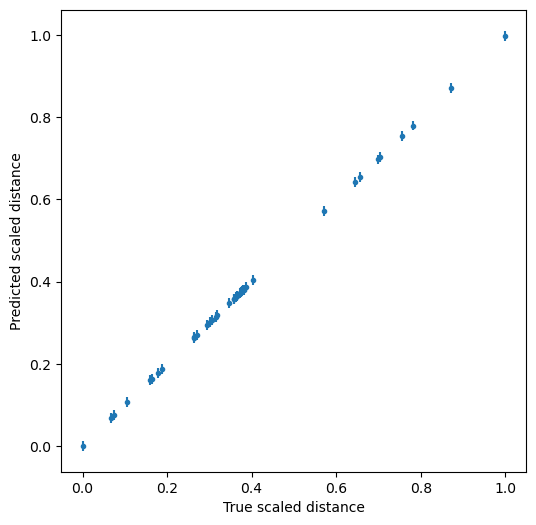

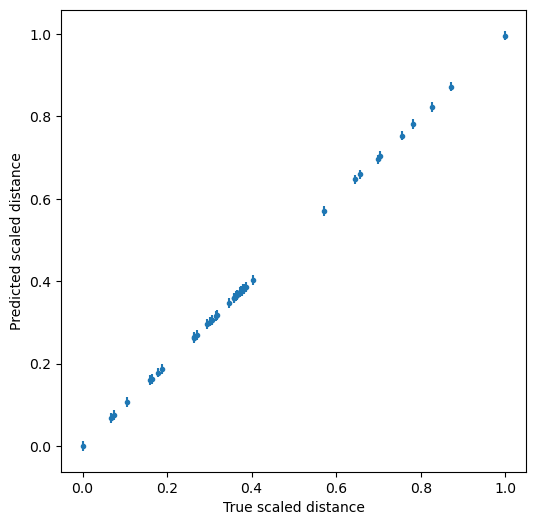

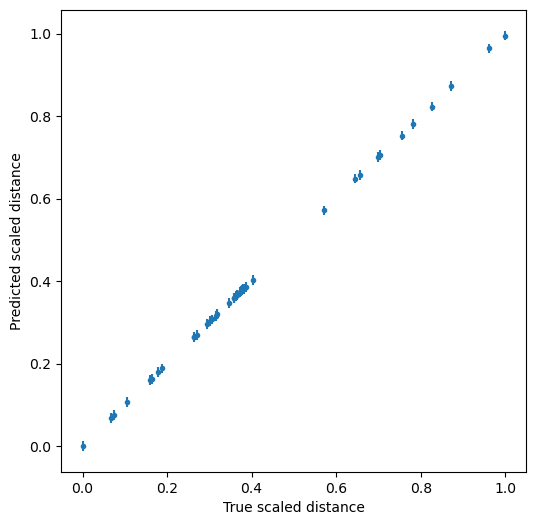

In [72]:
for model, train_x, train_y in zip(models, train_x_list, train_y_list):
    posterior = model.posterior(train_x)
    mean = np.array(posterior.mean.detach().reshape(-1))
    std = np.array(posterior.stddev.detach().reshape(-1))

    fig, ax = plt.subplots(figsize = (6,6))

    ax.errorbar(np.array(train_y), mean, yerr = std, linestyle = '', marker = '.')
    #ax.plot(train_y, train_y)
    ax.set_xlabel('True scaled distance')
    ax.set_ylabel('Predicted scaled distance')

In [59]:
# Helper function to create contour plots for qLogNoisyExpectedImprovement
def plot_qlognei_contour(acq_func, fixed_dim, fixed_val, x_range, y_range, dim_labels, title, candidates = candidates):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Compute qLogNoisyExpectedImprovement values at each grid point individually
    acq_func_values = []
    for i in range(grid_tensor.shape[0]):
        point = grid_tensor[i].unsqueeze(0)  # Make it a batch of 1
        acq_value = acq_func(point).item()  # Evaluate and get scalar value
        acq_func_values.append(acq_value)

    acq_func_values = np.array(acq_func_values).reshape(X.shape)  # Reshape to match grid

    dims = [0,1,2]
    dims.remove(fixed_dim)
    # Plot the contour of qLogNoisyExpectedImprovement
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, acq_func_values, levels=50, cmap="inferno")  # Inferno color map for acquisition function
    plt.scatter(candidates[:,dims[0]], candidates[:,dims[1]], marker = '*')
    plt.colorbar(cp, label="qLogNEI Acquisition Value")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

In [60]:
def plot_contour_fixed_dimension(model, fixed_dim, fixed_val, x_range, y_range, dim_labels, title):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict with the model
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)
        mean = preds.mean.numpy().reshape(X.shape)  # Reshape to match grid

    # Plot the contour
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, mean, levels=50, cmap="viridis")
    plt.colorbar(cp, label="Predicted Mean")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()


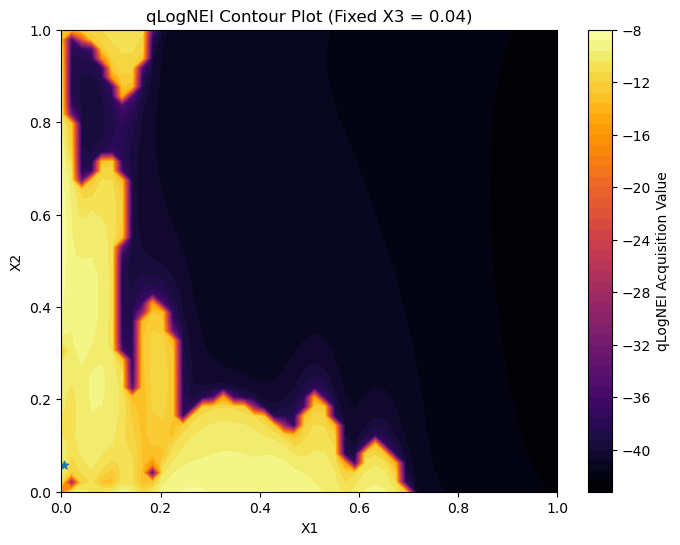

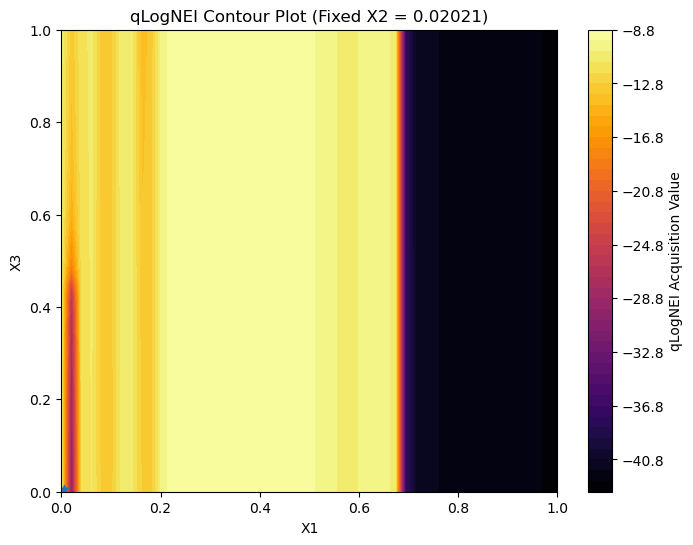

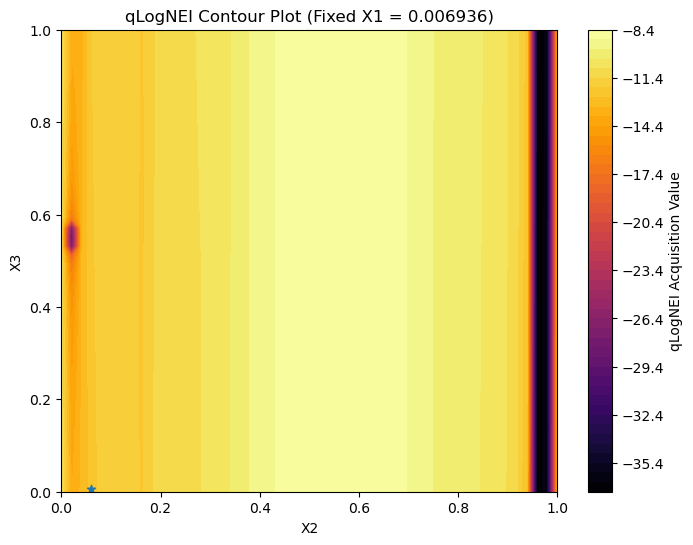

In [61]:

acq_func = acqfs[-1]
candidates = candidates_list[-1]
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)



# Plot 2D contour slices of qLogNEI by fixing each dimension at a particular value
fixed_vals = true_min # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=2, fixed_val=fixed_vals[2], 
                     x_range=x, y_range=y, 
                     dim_labels=["X1", "X2"], 
                     title=f"qLogNEI Contour Plot (Fixed X3 = {true_min[2]})", candidates =  candidates)

# Slice along X1 and X3, fixing X2 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=1, fixed_val=fixed_vals[1], 
                     x_range=x, y_range=z, 
                     dim_labels=["X1", "X3"], 
                     title=f"qLogNEI Contour Plot (Fixed X2 = {true_min[1]})", candidates = candidates)

# Slice along X2 and X3, fixing X1 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=0, fixed_val=fixed_vals[0], 
                     x_range=y, y_range=z, 
                     dim_labels=["X2", "X3"], 
                     title=f"qLogNEI Contour Plot (Fixed X1 = {true_min[0]})", candidates = candidates)

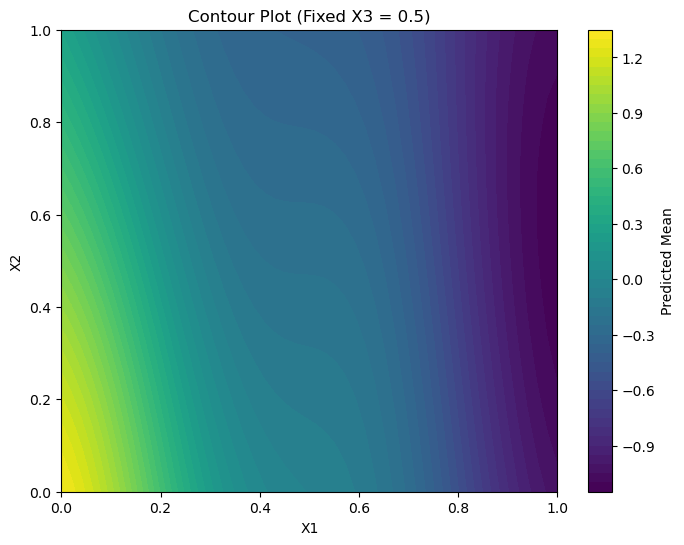

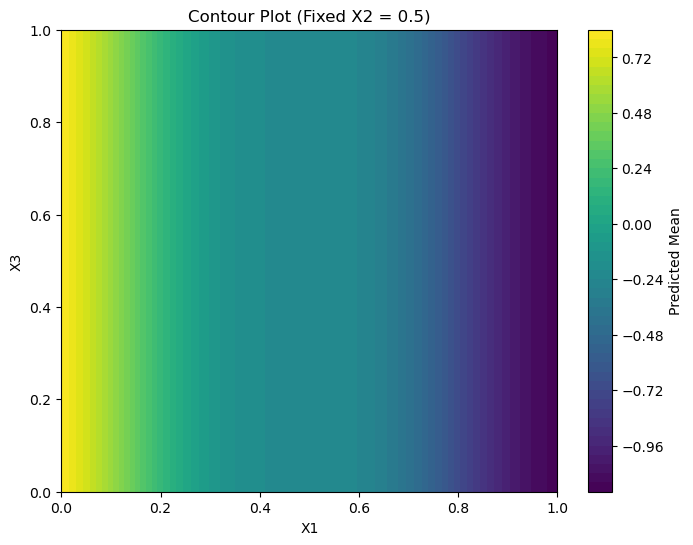

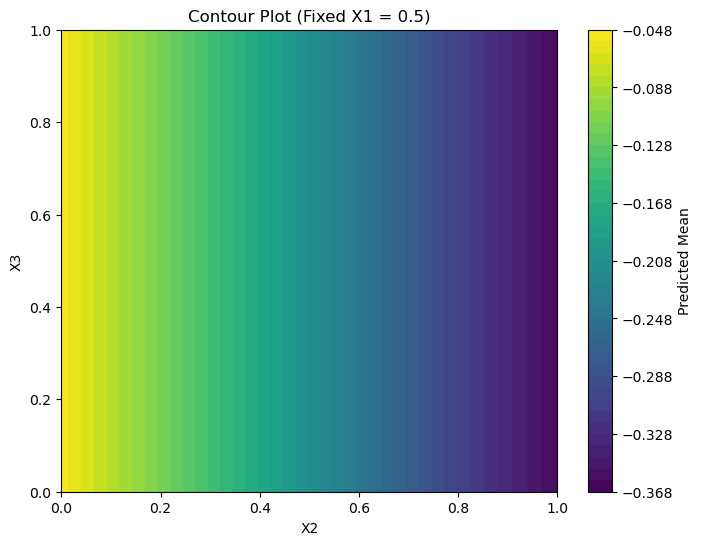

In [62]:
model_nei = models[-1]

# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Plot 2D contour slices by fixing each dimension at a particular value
fixed_vals = [0.5, 0.5, 0.5]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=2, fixed_val=fixed_vals[2], 
                             x_range=x, y_range=y, 
                             dim_labels=["X1", "X2"], 
                             title="Contour Plot (Fixed X3 = 0.5)")


# Slice along X1 and X3, fixing X2 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=1, fixed_val=fixed_vals[1], 
                             x_range=x, y_range=z, 
                             dim_labels=["X1", "X3"], 
                             title="Contour Plot (Fixed X2 = 0.5)")

# Slice along X2 and X3, fixing X1 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=0, fixed_val=fixed_vals[0], 
                             x_range=y, y_range=z, 
                             dim_labels=["X2", "X3"], 
                             title="Contour Plot (Fixed X1 = 0.5)")

In [48]:
# compare to true